# Case Study - Freddie Mac Bonds


## 1. Pricing the Callable Bond


### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`


The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.


In [2]:
FILE_BOND = 'data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = 'data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'

### Bond Info


In [3]:
import pandas as pd
import numpy as np
import math

info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info_core = info[[KEY_CALLABLE]]
info_core.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call","Date of First Possible Call"], :])

,FHLMC 4.41 01/28/30
info,
CUSIP,3134HA4V2
Issuer,FREDDIE MAC
Maturity Type,CALLABLE
Issuer Industry,GOVT AGENCY
Amount Issued,"10,000,000"
Cpn Rate,4.41%
Cpn Freq,2
Date Quoted,2025-02-13
Date Issued,2025-01-28


### Quoted Values


In [4]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes_core = quotes[[KEY_CALLABLE]]
quotes_core.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 4.41 01/28/30
quotes,
Date Quoted,2025-02-13
TTM,4.96
Clean Price,99.89
Dirty Price,100.09
Accrued Interest,0.20
YTM Call,4.45
YTM Maturity,4.43
Duration,4.50
Modified Duration,4.40


### Discount Curves


In [5]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

Also calculate the price of the `hypothetical` bonds, where we consider a non-callable version of the callable bond with 
* maturity unchanged
* maturity at the call date.


In [6]:
def _pick_reference_key(info, key_callable):
    candidates = [k for k in info.columns if k != key_callable]
    if len(candidates) == 0:
        raise ValueError("No reference bond found in info table.")
    # choose bond with maturity closest to callable maturity
    tgt = pd.Timestamp(info.loc["Date Matures", key_callable])
    mats = pd.Series({k: pd.Timestamp(info.loc["Date Matures", k]) for k in candidates})
    return (mats - tgt).abs().idxmin()

def _coupon_schedule(issue_date, maturity_date, freq):
    step_months = int(round(12 / freq))
    d = pd.Timestamp(issue_date)
    maturity_date = pd.Timestamp(maturity_date)
    dates = []
    while d <= maturity_date:
        dates.append(d)
        d = d + pd.DateOffset(months=step_months)
    if dates[-1] != maturity_date:
        dates.append(maturity_date)
    return pd.DatetimeIndex(dates)

def _interp_discount(ttm, discs):
    x = discs.index.astype(float).values
    y = discs["discount"].astype(float).values
    return float(np.interp(ttm, x, y))

def price_straight_from_curve(bond_key, info, discs, maturity_override=None, par=100.0):
    quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
    issue_date = pd.Timestamp(info.loc["Date Issued", bond_key])
    maturity = pd.Timestamp(maturity_override if maturity_override is not None else info.loc["Date Matures", bond_key])

    cpn = float(info.loc["Cpn Rate", bond_key])      # annual coupon rate, decimal
    freq = int(info.loc["Cpn Freq", bond_key])       # payments per year
    coupon_amt = par * cpn / freq

    sched = _coupon_schedule(issue_date, maturity, freq)

    # Previous / next coupon around quote date (for accrued interest)
    prev_cpn = sched[sched <= quote_date].max()
    next_cpn = sched[sched > quote_date].min()
    if pd.isna(prev_cpn):
        prev_cpn = issue_date
    if pd.isna(next_cpn):
        next_cpn = maturity

    accrual_frac = (quote_date - prev_cpn).days / (next_cpn - prev_cpn).days
    accrued = coupon_amt * accrual_frac

    # Future cash flows discounted from curve
    cf_dates = sched[sched > quote_date]
    ttms = np.array([(d - quote_date).days / 365.25 for d in cf_dates], dtype=float)

    cfs = np.full(len(cf_dates), coupon_amt, dtype=float)
    cfs[-1] += par

    dfs = np.array([_interp_discount(t, discs) for t in ttms], dtype=float)
    dirty = float(np.sum(cfs * dfs))
    clean = dirty - accrued

    return {
        "bond": bond_key,
        "maturity_used": maturity.date(),
        "dirty_model": dirty,
        "clean_model": clean,
        "accrued_model": accrued
    }

# Identify reference bond if not predefined
if "KEY_REFERENCE" not in globals():
    KEY_REFERENCE = _pick_reference_key(info, KEY_CALLABLE)

call_date = pd.Timestamp(info.loc["Date Next Call", KEY_CALLABLE])

rows = []
# 1) Callable bond (priced as straight bond to maturity from discount curve)
rows.append({"case": "callable (straight to maturity)", **price_straight_from_curve(KEY_CALLABLE, info, discs)})

# 2) Reference bond
rows.append({"case": "reference", **price_straight_from_curve(KEY_REFERENCE, info, discs)})

# 3) Hypothetical: non-callable version of callable, maturity unchanged
rows.append({"case": "hypo callable non-callable, same maturity", **price_straight_from_curve(KEY_CALLABLE, info, discs)})

# 4) Hypothetical: non-callable version of callable, maturity set to call date
rows.append({"case": "hypo callable non-callable, matures at call date", **price_straight_from_curve(KEY_CALLABLE, info, discs, maturity_override=call_date)})

out = pd.DataFrame(rows).set_index("case")

# Add market comparables when available
for idx in out.index:
    b = out.loc[idx, "bond"]
    if b in quotes.columns:
        out.loc[idx, "dirty_mkt"] = float(quotes.loc["Dirty Price", b])
        out.loc[idx, "clean_mkt"] = float(quotes.loc["Clean Price", b])

out[["bond", "maturity_used", "dirty_model", "clean_model", "accrued_model", "dirty_mkt", "clean_mkt"]]

,bond,maturity_used,dirty_model,clean_model,accrued_model,dirty_mkt,clean_mkt
case,,,,,,,
callable (straight to maturity),FHLMC 4.41 01/28/30,2030-01-28,101.410165,101.215248,0.194917,100.089000,99.8930
reference,FHLMC 1 1/4 01/29/30,2030-01-29,87.243000,87.191205,0.051796,85.161583,85.1095
"hypo callable non-callable, same maturity",FHLMC 4.41 01/28/30,2030-01-28,101.410165,101.215248,0.194917,100.089000,99.8930
"hypo callable non-callable, matures at call date",FHLMC 4.41 01/28/30,2028-01-28,100.903803,100.708886,0.194917,100.089000,99.8930


### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.


In [7]:
# 1.2 Forward price of the hypothetical (non-callable) bond at call date

# Underlying = hypothetical non-callable version of KEY_CALLABLE
bond_key = KEY_CALLABLE

quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
call_date = pd.Timestamp(info.loc["Date Next Call", bond_key])
maturity = pd.Timestamp(info.loc["Date Matures", bond_key])
issue_date = pd.Timestamp(info.loc["Date Issued", bond_key])

cpn = float(info.loc["Cpn Rate", bond_key])
freq = int(info.loc["Cpn Freq", bond_key])
par = 100.0
coupon_amt = par * cpn / freq

# Full coupon schedule
sched = _coupon_schedule(issue_date, maturity, freq)

# Cash flows strictly after exercise date (forward delivers bond at call date)
cf_dates_fwd = sched[sched > call_date]
cfs_fwd = np.full(len(cf_dates_fwd), coupon_amt, dtype=float)
cfs_fwd[-1] += par  # add principal at final maturity

# Discount factors from t=0 curve
ttm_call = (call_date - quote_date).days / 365.25
df_call = _interp_discount(ttm_call, discs)

ttms_fwd = np.array([(d - quote_date).days / 365.25 for d in cf_dates_fwd], dtype=float)
dfs_fwd = np.array([_interp_discount(t, discs) for t in ttms_fwd], dtype=float)

# Forward dirty price at call date:
# F(0,T_call) = PV0(cashflows after T_call) / D(0,T_call)
forward_dirty = float(np.sum(cfs_fwd * dfs_fwd) / df_call)

# Also report a cc zero rate to call date from discount curve (useful for 1.3)
r_cc_to_call = -np.log(df_call) / ttm_call

pd.DataFrame(
    {
        "quote_date": [quote_date.date()],
        "call_date": [call_date.date()],
        "T_call_years": [ttm_call],
        "D(0,T_call)": [df_call],
        "cc_zero_to_call": [r_cc_to_call],
        "forward_dirty_at_call": [forward_dirty],
    }
).T.rename(columns={0: "value"})

,value
quote_date,2025-02-13
call_date,2028-01-28
T_call_years,2.954141
"D(0,T_call)",0.885738
cc_zero_to_call,0.041073
forward_dirty_at_call,100.571684


### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.


In [8]:
# 1.3 Approximate implied vol of the bond forward price
# Uses: discs, quotes, info, KEY_CALLABLE, and (optionally) ttm_call from 1.2

bond_key = KEY_CALLABLE

# Time to exercise (reuse from 1.2 if available)
if "ttm_call" not in globals():
    quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
    call_date = pd.Timestamp(info.loc["Date Next Call", bond_key])
    ttm_call = (call_date - quote_date).days / 365.25

# Quoted duration from table (per instructions)
D_quoted = float(quotes.loc["Duration", bond_key])

# Implied vol of forward RATE from table
sigma_rate_raw = float(quotes.loc["Implied Vol", bond_key])
sigma_rate = sigma_rate_raw / 100.0 if sigma_rate_raw > 1 else sigma_rate_raw  # handle 23.88 vs 0.2388

# Instantaneous cc forward rate f(T1) from discount curve:
# f(t) = - d/dt ln D(0,t), approximated by finite differences on curve grid.
x = discs.index.astype(float).values
d = discs["discount"].astype(float).values

def inst_fwd_cc(t, x, d):
    # local slope of ln D around t using neighboring curve points
    lnD = np.log(d)
    i = np.searchsorted(x, t)
    if i <= 0:
        slope = (lnD[1] - lnD[0]) / (x[1] - x[0])      # forward diff
    elif i >= len(x):
        slope = (lnD[-1] - lnD[-2]) / (x[-1] - x[-2])  # backward diff
    else:
        slope = (lnD[i] - lnD[i-1]) / (x[i] - x[i-1])  # local secant
    return -slope

f_T1 = inst_fwd_cc(ttm_call, x, d)

# Also compute spot-rate-at-T1 fallback (as allowed in prompt)
D_T1 = float(np.interp(ttm_call, x, d))
z_T1 = -np.log(D_T1) / ttm_call  # cc spot to T1

# Duration approximation:
# sigma_bond_fwd_price ≈ D * sigma_fwd_rate * f(T1)
sigma_bond_from_fwd = D_quoted * sigma_rate * f_T1
sigma_bond_from_spot = D_quoted * sigma_rate * z_T1  # fallback approximation

pd.DataFrame({
    "Duration_used": [D_quoted],
    "sigma_fwd_rate_raw_quote": [sigma_rate_raw],
    "sigma_fwd_rate_decimal": [sigma_rate],
    "T1_years": [ttm_call],
    "f_T1_cc_instantaneous": [f_T1],
    "z_T1_cc_spot_fallback": [z_T1],
    "sigma_bond_fwd_price_from_f(T1)": [sigma_bond_from_fwd],
    "sigma_bond_fwd_price_from_spot(T1)": [sigma_bond_from_spot],
}).T.rename(columns={0: "value"})

,value
Duration_used,4.496738
sigma_fwd_rate_raw_quote,23.879829
sigma_fwd_rate_decimal,0.238798
T1_years,2.954141
f_T1_cc_instantaneous,0.040385
z_T1_cc_spot_fallback,0.041073
sigma_bond_fwd_price_from_f(T1),0.043366
sigma_bond_fwd_price_from_spot(T1),0.044104


### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.


In [9]:
# 1.4 Black value of embedded call option and callable bond value
# (builds on 1.1/1.2; uses forward_dirty, df_call, ttm_call if already computed)

def _norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

# --- Reuse / rebuild key inputs from earlier parts ---
bond_key = KEY_CALLABLE
quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
call_date = pd.Timestamp(info.loc["Date Next Call", bond_key])

# If 1.2 vars are not in memory, recreate them
if "ttm_call" not in globals():
    ttm_call = (call_date - quote_date).days / 365.25

if "df_call" not in globals():
    df_call = _interp_discount(ttm_call, discs)

if "forward_dirty" not in globals():
    # Forward dirty price of hypothetical (non-callable) bond at call date
    maturity = pd.Timestamp(info.loc["Date Matures", bond_key])
    issue_date = pd.Timestamp(info.loc["Date Issued", bond_key])
    cpn = float(info.loc["Cpn Rate", bond_key])
    freq = int(info.loc["Cpn Freq", bond_key])
    par = 100.0
    coupon_amt = par * cpn / freq

    sched = _coupon_schedule(issue_date, maturity, freq)
    cf_dates_fwd = sched[sched > call_date]  # cashflows after delivery date
    cfs_fwd = np.full(len(cf_dates_fwd), coupon_amt, dtype=float)
    cfs_fwd[-1] += par

    ttms_fwd = np.array([(d - quote_date).days / 365.25 for d in cf_dates_fwd], dtype=float)
    dfs_fwd = np.array([_interp_discount(t, discs) for t in ttms_fwd], dtype=float)

    forward_dirty = float(np.sum(cfs_fwd * dfs_fwd) / df_call)

# Vol for Black should be vol of bond forward price (from 1.3 approximation)
if "sigma_bond_fwd" not in globals():
    duration = float(quotes.loc["Duration", bond_key])                     # quoted duration
    sigma_fwd_rate = float(quotes.loc["Implied Vol", bond_key]) / 100.0    # quoted rate vol (decimal)
    f_T1 = float(np.interp(ttm_call,
                           discs.index.astype(float).values,
                           discs["spot rate"].astype(float).values))        # allowed approximation
    sigma_bond_fwd = duration * sigma_fwd_rate * f_T1

# --- Black-76 call on forward price ---
K = float(info.loc["Strike", bond_key])   # call strike (price terms)
T = float(ttm_call)
sig = float(sigma_bond_fwd)

if sig <= 0 or T <= 0:
    call_pv = df_call * max(forward_dirty - K, 0.0)
    d1 = np.nan
    d2 = np.nan
else:
    volT = sig * math.sqrt(T)
    d1 = (math.log(forward_dirty / K) + 0.5 * sig * sig * T) / volT
    d2 = d1 - volT
    call_pv = df_call * (forward_dirty * _norm_cdf(d1) - K * _norm_cdf(d2))

# Callable bond value = straight (hypothetical non-callable) - embedded call option
if "out" in globals() and "dirty_model" in out.columns:
    straight_dirty = float(out.loc["hypo callable non-callable, same maturity", "dirty_model"])
    accrued = float(out.loc["hypo callable non-callable, same maturity", "accrued_model"])
else:
    straight = price_straight_from_curve(bond_key, info, discs)
    straight_dirty = float(straight["dirty_model"])
    accrued = float(straight["accrued_model"])

callable_dirty_model = straight_dirty - call_pv
callable_clean_model = callable_dirty_model - accrued

mkt_dirty = float(quotes.loc["Dirty Price", bond_key])
mkt_clean = float(quotes.loc["Clean Price", bond_key])

res_14 = pd.DataFrame({
    "T_call_years": [T],
    "D(0,T_call)": [df_call],
    "Forward_dirty_hypo": [forward_dirty],
    "K": [K],
    "sigma_bond_fwd": [sig],
    "d1": [d1],
    "d2": [d2],
    "Embedded_call_value_PV": [call_pv],
    "Straight_dirty_model": [straight_dirty],
    "Callable_dirty_model": [callable_dirty_model],
    "Callable_clean_model": [callable_clean_model],
    "Callable_dirty_mkt": [mkt_dirty],
    "Callable_clean_mkt": [mkt_clean],
    "Diff_dirty_model_minus_mkt": [callable_dirty_model - mkt_dirty],
    "Diff_clean_model_minus_mkt": [callable_clean_model - mkt_clean],
}, index=[bond_key])

res_14.T

,FHLMC 4.41 01/28/30
T_call_years,2.954141
"D(0,T_call)",0.885738
Forward_dirty_hypo,100.571684
K,100.000000
sigma_bond_fwd,0.044569
d1,0.112719
d2,0.036116
Embedded_call_value_PV,2.974590
Straight_dirty_model,101.410165
Callable_dirty_model,98.435575


### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?


In [10]:
# 1.5 YTM of callable bond under two assumptions:
# (i) never called (to maturity), (ii) certainly called (to next call date)

bond_key = KEY_CALLABLE
quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
issue_date = pd.Timestamp(info.loc["Date Issued", bond_key])

maturity_date = pd.Timestamp(info.loc["Date Matures", bond_key])
call_date = pd.Timestamp(info.loc["Date Next Call", bond_key])

cpn = float(info.loc["Cpn Rate", bond_key])           # decimal, e.g. 0.0441
freq = int(info.loc["Cpn Freq", bond_key])            # e.g. 2
par = 100.0
coupon_amt = par * cpn / freq

# market price input (use dirty price)
dirty_mkt = float(quotes.loc["Dirty Price", bond_key])

def _future_cfs(bond_key, maturity_override=None):
    maturity_used = pd.Timestamp(maturity_override if maturity_override is not None else info.loc["Date Matures", bond_key])
    sched = _coupon_schedule(issue_date, maturity_used, freq)
    cf_dates = sched[sched > quote_date]
    cfs = np.full(len(cf_dates), coupon_amt, dtype=float)
    cfs[-1] += par
    ttms = np.array([(d - quote_date).days / 365.25 for d in cf_dates], dtype=float)
    return ttms, cfs

def _price_from_ytm(y, ttms, cfs, freq):
    # Street-style periodic compounding with potentially non-integer periods
    return float(np.sum(cfs / (1 + y / freq) ** (freq * ttms)))

def _solve_ytm_bisect(target_dirty, ttms, cfs, freq, lo=-0.20, hi=1.00, tol=1e-12, max_iter=300):
    def f(y): return _price_from_ytm(y, ttms, cfs, freq) - target_dirty

    flo, fhi = f(lo), f(hi)
    # expand bracket if needed
    k = 0
    while flo * fhi > 0 and k < 50:
        lo -= 0.10
        hi += 0.20
        flo, fhi = f(lo), f(hi)
        k += 1
    if flo * fhi > 0:
        raise RuntimeError("Could not bracket YTM root.")

    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        fm = f(mid)
        if abs(fm) < tol:
            return mid
        if flo * fm <= 0:
            hi, fhi = mid, fm
        else:
            lo, flo = mid, fm
    return 0.5 * (lo + hi)

def _norm_quote_yield(x):
    # Some sheets store yields as 4.45 (percent points), others 0.0445
    x = float(x)
    return x / 100.0 if x > 1.0 else x

# Solve model-implied YTMs from the same market dirty price
ttm_mat, cfs_mat = _future_cfs(bond_key, maturity_override=maturity_date)  # never called
ttm_call, cfs_call = _future_cfs(bond_key, maturity_override=call_date)     # certainly called

ytm_never_called = _solve_ytm_bisect(dirty_mkt, ttm_mat, cfs_mat, freq)
ytm_certainly_called = _solve_ytm_bisect(dirty_mkt, ttm_call, cfs_call, freq)

# Quoted comparables
ytm_call_quoted = _norm_quote_yield(quotes.loc["YTM Call", bond_key])
ytm_mat_quoted  = _norm_quote_yield(quotes.loc["YTM Maturity", bond_key])

out_15 = pd.DataFrame(
    [
        {
            "assumption": "never called (to maturity)",
            "ytm_model": ytm_never_called,
            "ytm_quoted": ytm_mat_quoted,
            "diff_bps (model-quoted)": 1e4 * (ytm_never_called - ytm_mat_quoted),
        },
        {
            "assumption": "certainly called (to next call date)",
            "ytm_model": ytm_certainly_called,
            "ytm_quoted": ytm_call_quoted,
            "diff_bps (model-quoted)": 1e4 * (ytm_certainly_called - ytm_call_quoted),
        },
    ]
)

out_15.style.format(
    {
        "ytm_model": "{:.4%}",
        "ytm_quoted": "{:.4%}",
        "diff_bps (model-quoted)": "{:+.2f}",
    }
)

,assumption,ytm_model,ytm_quoted,diff_bps (model-quoted)
0,never called (to maturity),4.4343%,4.4338%,+0.05
1,certainly called (to next call date),4.4508%,4.4483%,+0.25


In the table above, the calculated and quoted YTMs align very closely; however, our model produces slightly higher values for both YTM-to-maturity and YTM-to-next-call, with differences of less than 1 basis point.

### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.


In [11]:
# 1.6 Duration of hypothetical vs callable bond
# Builds on 1.1-1.4 logic (curve-based valuation + Black option on forward bond price)

import math
import numpy as np
import pandas as pd

# ---------- small helpers ----------
def _norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def _interp_series(ttm, x_index, y_values):
    x = np.asarray(x_index, dtype=float)
    y = np.asarray(y_values, dtype=float)
    return float(np.interp(float(ttm), x, y))

def _interp_discount_local(ttm, discs_local):
    return _interp_series(ttm, discs_local.index.values, discs_local["discount"].values)

def _interp_spot_local(ttm, discs_local):
    # uses spot-rate column if present; otherwise backs it out from discount
    if "spot rate" in discs_local.columns:
        return _interp_series(ttm, discs_local.index.values, discs_local["spot rate"].values)
    d = _interp_discount_local(ttm, discs_local)
    return -np.log(d) / max(float(ttm), 1e-8)

def _black_call_from_forward(F, K, sigma, T, df):
    if sigma <= 0 or T <= 0:
        return df * max(F - K, 0.0)
    volT = sigma * math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * sigma * sigma * T) / volT
    d2 = d1 - volT
    return df * (F * _norm_cdf(d1) - K * _norm_cdf(d2))

def _bump_curve_parallel(discs_in, bump_bp):
    # bump in continuously compounded rates; keep both spot and discount aligned
    b = bump_bp / 10000.0
    out = discs_in.copy()
    t = out.index.astype(float).values
    out["discount"] = out["discount"].astype(float).values * np.exp(-b * t)
    if "spot rate" in out.columns:
        out["spot rate"] = out["spot rate"].astype(float).values + b
    return out

# ---------- valuation components ----------
def _hypothetical_dirty_price(discs_local):
    # non-callable version of callable bond, full maturity
    return price_straight_from_curve(KEY_CALLABLE, info, discs_local)["dirty_model"]

def _forward_dirty_hypothetical_at_call(discs_local):
    bond_key = KEY_CALLABLE
    quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
    call_date = pd.Timestamp(info.loc["Date Next Call", bond_key])
    maturity = pd.Timestamp(info.loc["Date Matures", bond_key])
    issue_date = pd.Timestamp(info.loc["Date Issued", bond_key])

    cpn = float(info.loc["Cpn Rate", bond_key])
    freq = int(info.loc["Cpn Freq", bond_key])
    par = 100.0
    coupon_amt = par * cpn / freq

    sched = _coupon_schedule(issue_date, maturity, freq)
    cf_dates_fwd = sched[sched > call_date]
    cfs_fwd = np.full(len(cf_dates_fwd), coupon_amt, dtype=float)
    cfs_fwd[-1] += par

    T_call = (call_date - quote_date).days / 365.25
    df_call = _interp_discount_local(T_call, discs_local)

    ttms = np.array([(d - quote_date).days / 365.25 for d in cf_dates_fwd], dtype=float)
    dfs = np.array([_interp_discount_local(t, discs_local) for t in ttms], dtype=float)

    F_dirty = float(np.sum(cfs_fwd * dfs) / df_call)
    return F_dirty, T_call, df_call

def _sigma_bond_from_rate_vol(discs_local, T_call):
    # from part 1.3: sigma_bond ≈ D * sigma_fwd_rate * f(T1)
    D_used = float(quotes.loc["Duration", KEY_CALLABLE])  # as requested in 1.3
    sigma_rate = float(quotes.loc["Implied Vol", KEY_CALLABLE])
    if sigma_rate > 1.0:  # convert percent to decimal if needed
        sigma_rate /= 100.0

    # per instruction: spot at T1 is acceptable approximation for f(T1)
    f_T1 = _interp_spot_local(T_call, discs_local)
    sigma_bond = D_used * sigma_rate * f_T1
    return sigma_bond, D_used, sigma_rate, f_T1

def _callable_dirty_value(discs_local):
    P_hypo = _hypothetical_dirty_price(discs_local)
    F, T_call, df_call = _forward_dirty_hypothetical_at_call(discs_local)
    sigma_bond, D_used, sigma_rate, f_T1 = _sigma_bond_from_rate_vol(discs_local, T_call)
    K = float(info.loc["Strike", KEY_CALLABLE])

    call_embedded = _black_call_from_forward(F=F, K=K, sigma=sigma_bond, T=T_call, df=df_call)
    P_callable = P_hypo - call_embedded
    return {
        "P_hypo_dirty": P_hypo,
        "F_hypo_at_call": F,
        "T_call": T_call,
        "df_call": df_call,
        "sigma_bond": sigma_bond,
        "f_T1": f_T1,
        "embedded_call": call_embedded,
        "P_callable_dirty": P_callable,
    }

def _effective_duration(price_down, price_base, price_up, dy=1e-4):
    # central-difference effective (modified) duration
    return (price_down - price_up) / (2.0 * price_base * dy)

# ---------- base and bumped valuations ----------
bp = 1.0
discs_up = _bump_curve_parallel(discs, +bp)    # rates up 1bp
discs_dn = _bump_curve_parallel(discs, -bp)    # rates down 1bp

base = _callable_dirty_value(discs)
up = _callable_dirty_value(discs_up)
dn = _callable_dirty_value(discs_dn)

P_hypo_0 = base["P_hypo_dirty"]
P_hypo_up = up["P_hypo_dirty"]
P_hypo_dn = dn["P_hypo_dirty"]

P_call_0 = base["P_callable_dirty"]
P_call_up = up["P_callable_dirty"]
P_call_dn = dn["P_callable_dirty"]

dur_hypo_eff = _effective_duration(P_hypo_dn, P_hypo_0, P_hypo_up, dy=1e-4)
dur_call_eff = _effective_duration(P_call_dn, P_call_0, P_call_up, dy=1e-4)

# optional Macaulay conversion using quoted YTM maturity
ytm_mat = float(quotes.loc["YTM Maturity", KEY_CALLABLE])
if ytm_mat > 1.0:
    ytm_mat /= 100.0
freq = int(info.loc["Cpn Freq", KEY_CALLABLE])
dur_hypo_macaulay_approx = dur_hypo_eff * (1.0 + ytm_mat / freq)
dur_call_macaulay_approx = dur_call_eff * (1.0 + ytm_mat / freq)

# quoted comparables
quoted_duration = float(quotes.loc["Duration", KEY_CALLABLE])
quoted_mod_duration = float(quotes.loc["Modified Duration", KEY_CALLABLE]) if "Modified Duration" in quotes.index else np.nan

out_16 = pd.DataFrame({
    "metric": [
        "hypothetical_dirty_base",
        "callable_dirty_base",
        "hypothetical_effective_mod_duration",
        "callable_effective_mod_duration",
        "hypothetical_macaulay_approx",
        "callable_macaulay_approx",
        "quoted_duration",
        "quoted_modified_duration",
    ],
    "value": [
        P_hypo_0,
        P_call_0,
        dur_hypo_eff,
        dur_call_eff,
        dur_hypo_macaulay_approx,
        dur_call_macaulay_approx,
        quoted_duration,
        quoted_mod_duration,
    ]
})

out_16

,metric,value
0,hypothetical_dirty_base,101.410165
1,callable_dirty_base,98.435575
2,hypothetical_effective_mod_duration,4.500727
3,callable_effective_mod_duration,4.254153
4,hypothetical_macaulay_approx,4.600505
5,callable_macaulay_approx,4.348465
6,quoted_duration,4.496738
7,quoted_modified_duration,4.399211


The table shows that the hypothetical bond closely matches the quoted benchmark, while callability reduces both the bond’s price and its duration relative to the quoted duration.

### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.


In [12]:
# 1.7 OAS of the callable bond
# Builds on prior parts (1.1-1.6): info, quotes, discs, KEY_CALLABLE, _coupon_schedule, _interp_discount, price_straight_from_curve

bond_key = KEY_CALLABLE
par = 100.0

quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
issue_date = pd.Timestamp(info.loc["Date Issued", bond_key])
maturity = pd.Timestamp(info.loc["Date Matures", bond_key])
call_date = pd.Timestamp(info.loc["Date Next Call", bond_key])

cpn = float(info.loc["Cpn Rate", bond_key])
freq = int(info.loc["Cpn Freq", bond_key])
coupon_amt = par * cpn / freq
K = float(info.loc["Strike", bond_key]) if "Strike" in info.index else 100.0

T_call = (call_date - quote_date).days / 365.25
dirty_mkt = float(quotes.loc["Dirty Price", bond_key])

def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def black_call_forward(F, K, sigma, T, df):
    # Price at t=0 of a call on forward F with discount factor df to expiry
    if sigma <= 0 or T <= 0:
        return df * max(F - K, 0.0)
    vol_sqrt_t = sigma * math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * sigma * sigma * T) / vol_sqrt_t
    d2 = d1 - vol_sqrt_t
    return df * (F * norm_cdf(d1) - K * norm_cdf(d2))

def shifted_discounts(discs_in, spread_cc):
    # Parallel cc shift: D_s(0,t) = D(0,t) * exp(-s*t)
    d = discs_in.copy()
    t = d.index.astype(float).to_numpy()
    d["discount"] = d["discount"].astype(float).to_numpy() * np.exp(-spread_cc * t)
    return d

def forward_dirty_hypo(discs_in):
    # Forward dirty price of hypothetical non-callable bond at call date
    sched = _coupon_schedule(issue_date, maturity, freq)
    cf_dates = sched[sched > call_date]  # strictly after delivery date
    cfs = np.full(len(cf_dates), coupon_amt, dtype=float)
    cfs[-1] += par

    ttms = np.array([(d - quote_date).days / 365.25 for d in cf_dates], dtype=float)
    dfs = np.array([_interp_discount(t, discs_in) for t in ttms], dtype=float)
    df_call = _interp_discount(T_call, discs_in)

    return float(np.sum(cfs * dfs) / df_call)

def pick_sigma_bond_fwd(discs_in):
    # Prefer result from 1.3 if it exists; otherwise construct approximation from quoted inputs
    if "sigma_bond_fwd" in globals():
        return float(sigma_bond_fwd)

    # fallback approximation from 1.3 formula:
    # sigma_bond_fwd_price ≈ Duration * sigma_fwd_rate * f(T1)
    D_mod = float(quotes.loc["Modified Duration", bond_key]) if "Modified Duration" in quotes.index else float(quotes.loc["Duration", bond_key])
    sigma_rate = float(quotes.loc["Implied Vol", bond_key]) / 100.0
    f_T1_approx = -math.log(_interp_discount(T_call, discs_in)) / T_call  # use spot-to-T1 as approximation
    return D_mod * sigma_rate * f_T1_approx

def callable_dirty_model(spread_cc):
    d_shift = shifted_discounts(discs, spread_cc)

    # hypothetical straight-bond dirty price under shifted curve
    hypo_dirty = float(price_straight_from_curve(bond_key, info, d_shift)["dirty_model"])

    # option value under shifted curve
    F = forward_dirty_hypo(d_shift)
    sigma = pick_sigma_bond_fwd(d_shift)
    df_call = _interp_discount(T_call, d_shift)
    call_val = black_call_forward(F, K, sigma, T_call, df_call)

    # callable = straight - embedded call
    return hypo_dirty - call_val

def objective(spread_cc):
    return callable_dirty_model(spread_cc) - dirty_mkt

# Bisection bracket (spread in decimal cc units, e.g. 0.001 = 10 bps)
lo, hi = -0.05, 0.05
f_lo, f_hi = objective(lo), objective(hi)

# Expand bracket if needed
for _ in range(6):
    if f_lo * f_hi <= 0:
        break
    lo *= 1.5
    hi *= 1.5
    f_lo, f_hi = objective(lo), objective(hi)

if f_lo * f_hi > 0:
    raise RuntimeError("Could not bracket OAS root. Try wider bounds.")

# Bisection solve
for _ in range(80):
    mid = 0.5 * (lo + hi)
    f_mid = objective(mid)
    if abs(f_mid) < 1e-10:
        break
    if f_lo * f_mid <= 0:
        hi, f_hi = mid, f_mid
    else:
        lo, f_lo = mid, f_mid

oas_cc = 0.5 * (lo + hi)
oas_bps = oas_cc * 1e4

# Compare with quoted OAS (usually in bps in this dataset)
quoted_oas_bps = float(quotes.loc["OAS Spread", bond_key]) if "OAS Spread" in quotes.index else np.nan

out_oas = pd.DataFrame(
    {
        "metric": [
            "market_dirty",
            "model_dirty_at_oas",
            "oas_cc_decimal",
            "oas_bps",
            "quoted_oas_bps",
            "difference_model_minus_quoted_bps",
        ],
        "value": [
            dirty_mkt,
            callable_dirty_model(oas_cc),
            oas_cc,
            oas_bps,
            quoted_oas_bps,
            oas_bps - quoted_oas_bps if pd.notna(quoted_oas_bps) else np.nan,
        ],
    }
)
out_oas

,metric,value
0,market_dirty,100.089000
1,model_dirty_at_oas,100.089000
2,oas_cc_decimal,-0.004686
3,oas_bps,-46.864314
4,quoted_oas_bps,-26.768085
5,difference_model_minus_quoted_bps,-20.096228


Our model understates OAS by about 20 bps, likely because it prices the embedded call as a single-date European option, while the bond is effectively Bermudan with multiple exercise opportunities; additional differences in the implied-volatility input or convention may also contribute to the gap.

### 1.8. Optional OTM Callables


There are a few other Freddie Mac callables that may be of interest.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money (OTM). 
* Expiring in 3 months, though code below changes it to 6 monhts, to match coupon.
* These don't have interesting convexity due to being so far OTM.


In [13]:
# KEY_CALLABLE = 'FHLMC 1 1/4 01/29/30'
# KEY_CALLABLE = 'FHLMC 0.97 01/28/28'

In [14]:
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call","Date of First Possible Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


In [15]:
quotes.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.95,4.96,4.96
Clean Price,90.14,85.11,99.89
Dirty Price,90.19,85.16,100.09
Accrued Interest,0.04,0.05,0.20
YTM Call,54.24,85.40,4.45
YTM Maturity,4.57,4.65,4.43
Duration,2.92,4.81,4.50
Modified Duration,2.85,4.70,4.40


In [16]:
# Compare callable valuation across Freddie Mac callables
# (builds on Parts 1.1 - 1.7 logic)

BONDS_TO_CHECK = [
    "FHLMC 0.97 01/28/28",
    "FHLMC 1 1/4 01/29/30",
    "FHLMC 4.41 01/28/30",
]

def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def black_call_on_forward(F, K, vol, T, df):
    # Price at t=0 of a European call on forward (Black-76)
    if T <= 0 or vol <= 0:
        return df * max(F - K, 0.0)
    srt = vol * math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * vol * vol * T) / srt
    d2 = d1 - srt
    return df * (F * norm_cdf(d1) - K * norm_cdf(d2))

def straight_dirty_price_from_curve(bond_key, info, discs, maturity_override=None, par=100.0):
    quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
    issue_date = pd.Timestamp(info.loc["Date Issued", bond_key])
    maturity = pd.Timestamp(maturity_override if maturity_override is not None else info.loc["Date Matures", bond_key])

    cpn = float(info.loc["Cpn Rate", bond_key])
    freq = int(info.loc["Cpn Freq", bond_key])
    coupon_amt = par * cpn / freq

    sched = _coupon_schedule(issue_date, maturity, freq)
    cf_dates = sched[sched > quote_date]
    if len(cf_dates) == 0:
        return np.nan

    ttms = np.array([(d - quote_date).days / 365.25 for d in cf_dates], dtype=float)
    dfs = np.array([_interp_discount(t, discs) for t in ttms], dtype=float)

    cfs = np.full(len(cf_dates), coupon_amt, dtype=float)
    cfs[-1] += par

    return float(np.sum(cfs * dfs))

def forward_dirty_at_exercise(bond_key, info, discs, use_coupon_aligned_exercise=True, par=100.0):
    quote_date = pd.Timestamp(info.loc["Date Quoted", bond_key])
    issue_date = pd.Timestamp(info.loc["Date Issued", bond_key])
    maturity = pd.Timestamp(info.loc["Date Matures", bond_key])

    cpn = float(info.loc["Cpn Rate", bond_key])
    freq = int(info.loc["Cpn Freq", bond_key])
    coupon_amt = par * cpn / freq

    call_date_raw = pd.Timestamp(info.loc["Date Next Call", bond_key])

    # Optional simplification from prompt: if next call is very near (about 3m), move to next coupon (~6m)
    sched_full = _coupon_schedule(issue_date, maturity, freq)
    next_coupon_after_quote = sched_full[sched_full > quote_date].min()

    call_date = call_date_raw
    t_call_raw = (call_date_raw - quote_date).days / 365.25
    if use_coupon_aligned_exercise and t_call_raw < 0.4:
        call_date = pd.Timestamp(next_coupon_after_quote)

    T = (call_date - quote_date).days / 365.25
    df_call = _interp_discount(T, discs)

    # Underlying forward is the hypothetical non-callable bond delivered at call_date:
    # include only cashflows strictly after call_date
    cf_dates_post = sched_full[sched_full > call_date]
    cfs_post = np.full(len(cf_dates_post), coupon_amt, dtype=float)
    cfs_post[-1] += par

    ttms_post = np.array([(d - quote_date).days / 365.25 for d in cf_dates_post], dtype=float)
    dfs_post = np.array([_interp_discount(t, discs) for t in ttms_post], dtype=float)

    F_dirty = float(np.sum(cfs_post * dfs_post) / df_call)
    return F_dirty, call_date, T, df_call

rows = []

for b in BONDS_TO_CHECK:
    if b not in info.columns:
        continue

    # 1) Hypothetical straight bond (non-callable, same maturity)
    dirty_hypo = straight_dirty_price_from_curve(b, info, discs)

    # 2) Forward dirty at modeled exercise date
    F_dirty, call_date_model, T_call, df_call = forward_dirty_at_exercise(
        b, info, discs, use_coupon_aligned_exercise=True
    )

    # 3) Vol mapping from quoted rate vol -> bond forward vol (Part 1.3 approximation)
    sigma_rate = float(quotes.loc["Implied Vol", b]) / 100.0
    mod_dur = float(quotes.loc["Modified Duration", b])

    # instantaneous f(T1) approximation: use spot at nearest curve node
    idx_near = np.abs(discs.index.values.astype(float) - T_call).argmin()
    f_T1_approx = float(discs["spot rate"].iloc[idx_near])

    sigma_bond_fwd = mod_dur * sigma_rate * f_T1_approx

    # 4) Black value of embedded call (Part 1.4)
    K = float(info.loc["Strike", b])  # strike is in price points
    call_val_0 = black_call_on_forward(F_dirty, K, sigma_bond_fwd, T_call, df_call)

    # 5) Callable model value = straight - embedded call
    dirty_callable_model = dirty_hypo - call_val_0
    dirty_mkt = float(quotes.loc["Dirty Price", b])

    rows.append({
        "bond": b,
        "next_call_raw": pd.Timestamp(info.loc["Date Next Call", b]).date(),
        "call_date_used": pd.Timestamp(call_date_model).date(),
        "T_call_years": T_call,
        "forward_dirty": F_dirty,
        "strike": K,
        "sigma_rate": sigma_rate,
        "f_T1_approx": f_T1_approx,
        "sigma_bond_fwd": sigma_bond_fwd,
        "embedded_call_value": call_val_0,
        "hypothetical_dirty": dirty_hypo,
        "callable_dirty_model": dirty_callable_model,
        "callable_dirty_mkt": dirty_mkt,
        "model_minus_mkt": dirty_callable_model - dirty_mkt,
    })

res = pd.DataFrame(rows).set_index("bond")
res

,next_call_raw,call_date_used,T_call_years,forward_dirty,strike,sigma_rate,f_T1_approx,sigma_bond_fwd,embedded_call_value,hypothetical_dirty,callable_dirty_model,callable_dirty_mkt,model_minus_mkt
bond,,,,,,,,,,,,,
FHLMC 0.97 01/28/28,2025-04-28,2025-04-28,0.202601,93.259885,100.0,0.195990,0.043743,0.024451,1.795088e-11,91.738418,91.738418,90.187111,1.551307
FHLMC 1 1/4 01/29/30,2025-04-29,2025-07-29,0.454483,88.526145,100.0,0.210934,0.043743,0.043338,8.872955e-06,87.243000,87.242992,85.161583,2.081408
FHLMC 4.41 01/28/30,2028-01-28,2028-01-28,2.954141,100.571684,100.0,0.238798,0.041492,0.043589,2.915109e+00,101.410165,98.495056,100.089000,-1.593944


### 1.9. ATM with 1-yr expiry

Try this alternate file `2025-02-18` for a recently-issued bond of size $1bn with a one-year expiration.
* Easier to see the negative convexity.
* Large size, recency should be more liquid.


In [17]:
FILE_BOND = 'data/callable_bonds_2025-02-18.xlsx'
# FILE_CURVE = '../data/discount_curve_2025-02-18.xlsx' (missing)
KEY_CALLABLE = 'FHLMC 4.55 02/11/28'

,metric,value
0,bond_used,FHLMC 4.55 02/11/28
1,market_dirty,99.83375
2,model_callable_dirty_base,99.652804
3,model_hypothetical_dirty_base,101.195765
4,embedded_call_pv_base,1.542961
5,local_convexity_hypothetical_25bp,8.2203
6,local_convexity_callable_25bp,-55.778299


,shift_bps,hypothetical_dirty,callable_dirty
0,-200.0,106.940449,102.252319
1,-150.0,105.441718,101.746069
2,-100.0,103.964700,101.172901
3,-50.0,102.509077,100.458432
4,-25.0,101.789190,100.038957
5,0.0,101.074534,99.580385
6,25.0,100.365071,99.087097
7,50.0,99.660763,98.564201
8,100.0,98.267459,97.449647
9,150.0,96.894323,96.271983


Text(0, 0.5, 'Dirty price')

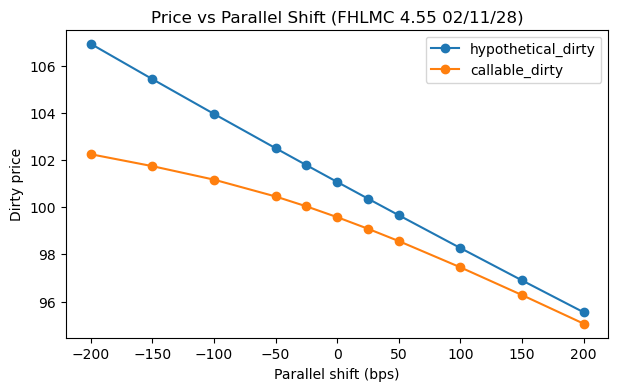

In [18]:
# 1.9 ATM with ~1y expiry (using SAME discount curve 'discs' from 1.1-1.8)

import numpy as np
import pandas as pd
from math import erf, sqrt, log

# --- Load alternate bond file (but keep discount curve unchanged) ---
FILE_BOND_ALT = "data/callable_bonds_2025-02-18.xlsx"
info_alt = pd.read_excel(FILE_BOND_ALT, sheet_name="info").set_index("info")
quotes_alt = pd.read_excel(FILE_BOND_ALT, sheet_name="quotes").set_index("quotes")

# Pick the most liquid bond with ~1y to next call (fallback: largest issue size)
candidate_cols = list(info_alt.columns)
tmp = pd.DataFrame({
    "bond": candidate_cols,
    "amount_issued": [float(info_alt.loc["Amount Issued", c]) for c in candidate_cols],
    "quote_date": [pd.Timestamp(info_alt.loc["Date Quoted", c]) for c in candidate_cols],
    "next_call": [pd.Timestamp(info_alt.loc["Date Next Call", c]) for c in candidate_cols],
})
tmp["ttm_call"] = (tmp["next_call"] - tmp["quote_date"]).dt.days / 365.25
near_1y = tmp[(tmp["ttm_call"] >= 0.75) & (tmp["ttm_call"] <= 1.25)]

if len(near_1y) > 0:
    KEY_ATM = near_1y.sort_values("amount_issued", ascending=False).iloc[0]["bond"]
else:
    KEY_ATM = tmp.sort_values("amount_issued", ascending=False).iloc[0]["bond"]

# If your notebook already has these helpers, they will be reused.
if "_coupon_schedule" not in globals():
    def _coupon_schedule(issue_date, maturity_date, freq):
        step_months = int(round(12 / freq))
        d = pd.Timestamp(issue_date)
        maturity_date = pd.Timestamp(maturity_date)
        dates = []
        while d <= maturity_date:
            dates.append(d)
            d = d + pd.DateOffset(months=step_months)
        if dates[-1] != maturity_date:
            dates.append(maturity_date)
        return pd.DatetimeIndex(dates)

if "_interp_discount" not in globals():
    def _interp_discount(ttm, discs_local):
        x = discs_local.index.astype(float).values
        y = discs_local["discount"].astype(float).values
        return float(np.interp(ttm, x, y))

def _norm_cdf(x):
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def _to_cc_spot_curve(discs_local):
    d = discs_local.copy()
    t = d.index.astype(float).values
    if "spot rate" in d.columns:
        r = d["spot rate"].astype(float).values
    else:
        # derive cc spot from discount, handle t=0 safely
        discv = d["discount"].astype(float).values
        r = np.where(t > 0, -np.log(discv) / t, 0.0)
    return t, r

def _shift_discounts_parallel(discs_local, shift_bps):
    t, r = _to_cc_spot_curve(discs_local)
    s = shift_bps / 10000.0
    r_shift = r + s
    d_new = discs_local.copy()
    d_new["spot rate"] = r_shift
    d_new["discount"] = np.exp(-r_shift * t)
    return d_new

def _price_straight_dirty_from_curve(bond_key, info_df, discs_local, maturity_override=None, par=100.0):
    qd = pd.Timestamp(info_df.loc["Date Quoted", bond_key])
    idt = pd.Timestamp(info_df.loc["Date Issued", bond_key])
    mat = pd.Timestamp(maturity_override if maturity_override is not None else info_df.loc["Date Matures", bond_key])

    cpn = float(info_df.loc["Cpn Rate", bond_key])
    freq = int(info_df.loc["Cpn Freq", bond_key])
    cpn_amt = par * cpn / freq

    sched = _coupon_schedule(idt, mat, freq)

    prev_cpn = sched[sched <= qd].max()
    next_cpn = sched[sched > qd].min()
    if pd.isna(prev_cpn):
        prev_cpn = idt
    if pd.isna(next_cpn):
        next_cpn = mat

    accrual_frac = (qd - prev_cpn).days / (next_cpn - prev_cpn).days
    accrued = cpn_amt * accrual_frac

    cf_dates = sched[sched > qd]
    ttms = np.array([(d - qd).days / 365.25 for d in cf_dates], dtype=float)

    cfs = np.full(len(cf_dates), cpn_amt, dtype=float)
    cfs[-1] += par

    dfs = np.array([_interp_discount(t, discs_local) for t in ttms], dtype=float)
    dirty = float(np.sum(cfs * dfs))
    clean = dirty - accrued
    return dirty, clean, accrued

def _forward_dirty_hypothetical_at_call(bond_key, info_df, discs_local, par=100.0):
    qd = pd.Timestamp(info_df.loc["Date Quoted", bond_key])
    call_date = pd.Timestamp(info_df.loc["Date Next Call", bond_key])
    mat = pd.Timestamp(info_df.loc["Date Matures", bond_key])
    idt = pd.Timestamp(info_df.loc["Date Issued", bond_key])

    cpn = float(info_df.loc["Cpn Rate", bond_key])
    freq = int(info_df.loc["Cpn Freq", bond_key])
    cpn_amt = par * cpn / freq

    sched = _coupon_schedule(idt, mat, freq)
    cf_dates = sched[sched > call_date]
    cfs = np.full(len(cf_dates), cpn_amt, dtype=float)
    cfs[-1] += par

    t_call = (call_date - qd).days / 365.25
    df_call = _interp_discount(t_call, discs_local)

    ttms = np.array([(d - qd).days / 365.25 for d in cf_dates], dtype=float)
    dfs = np.array([_interp_discount(t, discs_local) for t in ttms], dtype=float)

    fwd_dirty = float(np.sum(cfs * dfs) / df_call)
    return fwd_dirty, t_call, df_call

def _black_call_fwd(F, K, vol, T):
    # Black formula on forward (returns undiscounted forward-option value)
    if vol <= 0 or T <= 0:
        return max(F - K, 0.0)
    sig_sqrt_t = vol * np.sqrt(T)
    d1 = (np.log(F / K) + 0.5 * vol**2 * T) / sig_sqrt_t
    d2 = d1 - sig_sqrt_t
    return F * _norm_cdf(d1) - K * _norm_cdf(d2)

def _callable_dirty_model(bond_key, info_df, quotes_df, discs_local):
    # Straight bond value
    straight_dirty, _, _ = _price_straight_dirty_from_curve(bond_key, info_df, discs_local)

    # Forward of hypothetical bond at call date
    F, T1, D01 = _forward_dirty_hypothetical_at_call(bond_key, info_df, discs_local)

    # Approx sigma of bond forward price from prior exercise
    D_mod = float(quotes_df.loc["Modified Duration", bond_key])
    sigma_rate = float(quotes_df.loc["Implied Vol", bond_key]) / 100.0

    # Use instantaneous forward approx by nearest spot at T1 (allowed simplification)
    t_grid = discs_local.index.astype(float).values
    t_near = float(t_grid[np.argmin(np.abs(t_grid - T1))])
    f_T1_approx = float(discs_local.loc[t_near, "spot rate"])

    sigma_bond = D_mod * sigma_rate * f_T1_approx
    K = float(info_df.loc["Strike", bond_key])

    call_fwd = _black_call_fwd(F, K, sigma_bond, T1)
    call_pv = D01 * call_fwd

    callable_dirty = straight_dirty - call_pv
    return callable_dirty, straight_dirty, call_pv

# --- Base valuation ---
callable_base, straight_base, call_pv_base = _callable_dirty_model(KEY_ATM, info_alt, quotes_alt, discs)
market_dirty = float(quotes_alt.loc["Dirty Price", KEY_ATM])

# --- Rate-shift grid for convexity visualization ---
shift_grid = np.array([-200, -150, -100, -50, -25, 0, 25, 50, 100, 150, 200], dtype=float)
rows = []
for s in shift_grid:
    ds = _shift_discounts_parallel(discs, s)
    hyp_dirty_s, _, _ = _price_straight_dirty_from_curve(KEY_ATM, info_alt, ds)  # non-callable hypothetical
    call_dirty_s, _, _ = _callable_dirty_model(KEY_ATM, info_alt, quotes_alt, ds)
    rows.append({"shift_bps": s, "hypothetical_dirty": hyp_dirty_s, "callable_dirty": call_dirty_s})

curve_cmp = pd.DataFrame(rows)

# Local convexity estimate around 0 shift using +/-25 bps
P_m = float(curve_cmp.loc[curve_cmp["shift_bps"] == -25, "callable_dirty"].iloc[0])
P_0 = float(curve_cmp.loc[curve_cmp["shift_bps"] == 0, "callable_dirty"].iloc[0])
P_p = float(curve_cmp.loc[curve_cmp["shift_bps"] == 25, "callable_dirty"].iloc[0])
dy = 25 / 10000
conv_local_callable = (P_p - 2 * P_0 + P_m) / (P_0 * dy**2)

P_m_h = float(curve_cmp.loc[curve_cmp["shift_bps"] == -25, "hypothetical_dirty"].iloc[0])
P_0_h = float(curve_cmp.loc[curve_cmp["shift_bps"] == 0, "hypothetical_dirty"].iloc[0])
P_p_h = float(curve_cmp.loc[curve_cmp["shift_bps"] == 25, "hypothetical_dirty"].iloc[0])
conv_local_hyp = (P_p_h - 2 * P_0_h + P_m_h) / (P_0_h * dy**2)

summary_19 = pd.DataFrame([
    {"metric": "bond_used", "value": KEY_ATM},
    {"metric": "market_dirty", "value": market_dirty},
    {"metric": "model_callable_dirty_base", "value": callable_base},
    {"metric": "model_hypothetical_dirty_base", "value": straight_base},
    {"metric": "embedded_call_pv_base", "value": call_pv_base},
    {"metric": "local_convexity_hypothetical_25bp", "value": conv_local_hyp},
    {"metric": "local_convexity_callable_25bp", "value": conv_local_callable},
])

display(summary_19)
display(curve_cmp)

# Optional quick visual check of negative convexity
ax = curve_cmp.plot(x="shift_bps", y=["hypothetical_dirty", "callable_dirty"], marker="o", figsize=(7,4),
                    title=f"Price vs Parallel Shift ({KEY_ATM})")
ax.set_xlabel("Parallel shift (bps)")
ax.set_ylabel("Dirty price")